# Cohort Building and Data Access Using the MIDRC BDF Imaging Hub

---

This notebook briefly demonstrates how to use the MIDRC Biomedical Imaging Hub (BIH) APIs to discover medical imaging datasets across the Biomedical Data Fabric (BDF), including those in data resources other than the MIDRC data commons.

Anything a user can do in the [MIDRC BIH Explorer graphical user interface](https://imaging-hub.data-commons.org/Explorer), including using complex search criteria to select similar subsets of images distributed across multiple repositories, can also be achieved programmatically using API requests.

by Chris Meyer, PhD

August 2025

## 1) Set up Python environment
---

### Download an API key file containing your credentials
---
1) Navigate to the MIDRC BIH login page in your browser: https://imaging-hub.data-commons.org/portal/login.
2) Navigate to the user profile page: https://imaging-hub.data-commons.org/portal/identity.
3) Click on the button "Create API Key" and save the `credentials.json` file somewhere safe as `bih-credentails.json`.

### Set local variables
---
Change the following `bcred` variable path to point to your credentials file downloaded from the MIDRC data portal following the instructions above.

In [203]:
bcred = "/Users/cgmeyer/Downloads/bih-credentials.json" # location of your MIDRC BIH credentials, downloaded from https://imaging-hub.data-commons.org/portal/identity by clicking "Create API key" button and saving the credentials.json locally
bapi = "https://imaging-hub.data-commons.org" # The base URL of the resource being queried. This shouldn't change for MIDRC BIH


### Install / Import Python Packages and Scripts

In [284]:
## The packages below may be necessary for users to install according to the imports necessary in the subsequent cells.
## Uncomment the lines for packages you may need to install

import sys
#!{sys.executable} -m pip install
#!{sys.executable} -m pip install --upgrade pandas
#!{sys.executable} -m pip install --upgrade --ignore-installed PyYAML
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install --upgrade gen3
#!{sys.executable} -m pip install pydicom
#!{sys.executable} -m pip install --upgrade Pillow
#!{sys.executable} -m pip install psmpy
#!{sys.executable} -m pip install python-gdcm --upgrade
#!{sys.executable} -m pip install pylibjpeg --upgrade


In [205]:
## Import Python Packages and scripts

import os, subprocess
import pandas as pd
import numpy as np
import pydicom
from PIL import Image
import glob
#import gdcm
#import pylibjpeg

# import some Gen3 packages
import gen3
from gen3.auth import Gen3Auth
from gen3.query import Gen3Query
from IPython.display import display

### Initiate instances of the Gen3 SDK Classes using your credentials file for authentication
---
Again, make sure the "bcred" directory path variable reflects the location of _your_ credentials file (path variables set above).

In [179]:
bauth = Gen3Auth(bapi, refresh_file=bcred) # authentication class
bquery = Gen3Query(bauth) # query class


## 2) Build Cohorts by Sending Queries to the MIDRC BIH Metadata API
---

Currently, there are four views of the imaging data in MIDRC BIH: datasets, patients, imaging studies, and imaging series. These four views correspond to four 






### Find Imaging Studies of Interest

* Here, we'll send a query to the `imaging_study` index, which is the default table view in the [MIDRC BIH data explorer GUI](https://data.midrc.org/explorer).
* The filters defined below can be added to, removed, or modified to return different subsets of imaging studies.
* If our query request is successful, the API response should be in JSON format. The response will be a list of structured data records, each corresponding to a single imaging study. 
* The Gen3 query service "guppy" has extensive documentation in GitHub [here](https://github.com/uc-cdis/guppy/blob/master/doc/queries.md), which will guide you through query syntax, available types of filters, operators, etc.

#### Fetch the Query Schema 
---

In order to see all the fields available to use in queries as filter parameters, we can send a request to [get the query schema/mapping](https://github.com/uc-cdis/guppy/blob/master/doc/queries.md#mapping-query). Here we specify the imaging_study index to see all the fields in BIH related to imaging studies.




In [218]:
query_string = """{
  _mapping {
    imaging_study
  }
}"""
bquery.graphql_query(query_string=query_string,variables=None)


{'data': {'_mapping': {'imaging_study': ['EthnicGroup',
    'PatientAge',
    'PatientID',
    'PatientSex',
    'StudyDescription',
    'StudyInstanceUID',
    '_imaging_study_id',
    'auth_resource_path',
    'collection_id',
    'commons_long_name',
    'commons_name',
    'data_contributor',
    'data_host',
    'data_url_doi',
    'disease_type',
    'license',
    'metadata_source_api',
    'metadata_source_date',
    'metadata_source_version',
    'node_id',
    'primary_site',
    'project_id',
    'race',
    'study_viewer_url',
    'subject_id',
    'submitter_id']}}}

#### Set some filter values to subset the imaging studies in BIH

In [206]:
## Find imaging studies with the following parameters:
StudyDescription = ["XR Chest AP or PA", 
                    "CHEST AP PORT",
                    "CHEST PORT 1 VIEW (RAD)-CS",
                    "CHEST PA & LATERAL (RAD)-CS",
                    "CHEST AP VIEWONLY",
                    "Portable Chest",
                    "Chest Portable",
                    "CHEST AP PORTABLE"]

## Filter studies based on some patient attributes:
PatientSex = "Male"

min_PatientAge = 65
max_PatientAge = 70

EthnicGroup = ["Non-Hispanic/Non-Latino",
                "Not Hispanic or Latino"]

race = ["Black",
        "Black or African American"]


In [207]:
studies = bquery.raw_data_download(
                    data_type="imaging_study",
                    fields=None,
                    filter_object={
                        "AND": [
                            {"IN": {"StudyDescription": StudyDescription}},
                            {"=": {"PatientSex": PatientSex}},
                            {"IN": {"EthnicGroup": EthnicGroup}},
                            {"IN": {"race": race}},
                            {"AND":[{">=":{"PatientAge":min_PatientAge}},{"<=":{"PatientAge":max_PatientAge}}]}
                        ]
                    },
                )


In [208]:
# Summarize the query response
if len(studies) > 0:
    study_ids = list(set([i['submitter_id'] for i in studies if 'submitter_id' in i])) ## make a list of the imaging study IDs returned
    platforms = list(set([rec['commons_name'][0] for rec in studies if 'commons_name' in rec])) ## make a list of the imaging study IDs returned
    subject_ids = list(set([rec['subject_id'][0] for rec in studies if 'subject_id' in rec])) ## make a list of the imaging studiy IDs returned
    print(f"Query returned {len(studies)} imaging studies for {len(subject_ids)} subjects across {len(platforms)} platforms: {platforms}.")
    print("Data is a list with rows like this:")
    for k,v in studies[0:1][0].items():
      print("\t\'{}' : '{}'".format(k,v))
else:
    print("Your query returned no data! Please, check that query parameters are valid.")

Query returned 1816 imaging studies for 729 subjects across 2 platforms: ['Stanford AIMI', 'MIDRC'].
Data is a list with rows like this:
	'_imaging_study_id' : 'bd43c06b-8314-4334-bff5-9ecb4712b002'
	'project_id' : 'AIMI-CheXpertPlus'
	'submitter_id' : 'patient34849_study1'
	'StudyDescription' : 'XR Chest AP or PA'
	'StudyInstanceUID' : 'patient34849_study1'
	'PatientAge' : '66'
	'PatientSex' : 'Male'
	'PatientID' : 'patient34849'
	'EthnicGroup' : 'Non-Hispanic/Non-Latino'
	'race' : '['Black']'
	'subject_id' : '['patient34849']'
	'collection_id' : '['CheXpert Plus']'
	'commons_long_name' : '['The Stanford Center for Artificial Intelligence in Medicine and Imaging (AIMI)']'
	'commons_name' : '['Stanford AIMI']'
	'data_contributor' : '[]'
	'data_host' : '[]'
	'data_url_doi' : '['https://stanfordaimi.azurewebsites.net/datasets/5158c524-d3ab-4e02-96e9-6ee9efc110a1']'
	'disease_type' : '['cardiovascular disease (CVD)']'
	'license' : '['https://stanfordaimi.azurewebsites.net/datasets/5158c52

In [209]:
studies_df = pd.DataFrame(studies)
display(studies_df)

,_imaging_study_id,project_id,submitter_id,StudyDescription,StudyInstanceUID,PatientAge,PatientSex,PatientID,EthnicGroup,race,...,data_host,data_url_doi,disease_type,license,metadata_source_api,metadata_source_date,metadata_source_version,primary_site,auth_resource_path,study_viewer_url
0,bd43c06b-8314-4334-bff5-9ecb4712b002,AIMI-CheXpertPlus,patient34849_study1,XR Chest AP or PA,patient34849_study1,66,Male,patient34849,Non-Hispanic/Non-Latino,[Black],...,[],[https://stanfordaimi.azurewebsites.net/datase...,[cardiovascular disease (CVD)],[https://stanfordaimi.azurewebsites.net/datase...,[],[],[],[Chest],/programs/AIMI/projects/CheXpertPlus,NaN
1,dc9de267-bb01-45cb-85a1-2b03e1b0be20,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.514382.5749498,XR Chest AP or PA,1.2.826.0.1.3680043.10.474.514382.5749498,67,Male,514382-037893,Not Hispanic or Latino,[Black or African American],...,[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1,https://data.midrc.org/ohif-viewer/viewer?Stud...
2,dabcc081-9d29-4e83-bb74-c601125faf4b,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.514382.86081,XR Chest AP or PA,1.2.826.0.1.3680043.10.474.514382.86081,70,Male,514382-001952,Not Hispanic or Latino,[Black or African American],...,[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1,https://data.midrc.org/ohif-viewer/viewer?Stud...
3,6067ab69-729e-49bd-aafd-b150cb39f669,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.302028.2288404,XR Chest AP or PA,1.2.826.0.1.3680043.10.474.302028.2288404,70,Male,302028-006077,Not Hispanic or Latino,[Black or African American],...,[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1,https://data.midrc.org/ohif-viewer/viewer?Stud...
4,848c744c-05c6-4e23-bd49-7b5a12db3132,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.514382.1806674,XR Chest AP or PA,1.2.826.0.1.3680043.10.474.514382.1806674,67,Male,514382-016212,Not Hispanic or Latino,[Black or African American],...,[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1,https://data.midrc.org/ohif-viewer/viewer?Stud...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,47b4a936-0d06-4d34-a1aa-547e46f29bee,MIDRC-Open-A1,2.16.840.1.114274.1818.56015435672087772309642...,XR Chest AP or PA,2.16.840.1.114274.1818.56015435672087772309642...,66,Male,10041569-XxCa8tviNEOuHeRAdgMA9Q,Not Hispanic or Latino,[Black or African American],...,[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-A1,https://data.midrc.org/ohif-viewer/viewer?Stud...
1812,c4fe4165-12f8-4596-ba3a-00bd3b9cc540,MIDRC-Open-A1,2.16.840.1.114274.1818.56117089168646181881828...,XR Chest AP or PA,2.16.840.1.114274.1818.56117089168646181881828...,65,Male,10041569-PaIE0aECkSX4vEbaKzvBQ,Not Hispanic or Latino,[Black or African American],...,[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-A1,https://data.midrc.org/ohif-viewer/viewer?Stud...
1813,431bed91-e111-473d-92a5-15a9403e5710,AIMI-CheXpertPlus,patient16529_study16,XR Chest AP or PA,patient16529_study16,65,Male,patient16529,Non-Hispanic/Non-Latino,[Black],...,[],[https://stanfordaimi.azurewebsites.net/datase...,[cardiovascular disease (CVD)],[https://stanfordaimi.azurewebsites.net/datase...,[],[],[],[Chest],/programs/AIMI/projects/CheXpertPlus,NaN
1814,ee7bad8d-fc9d-4a4b-899d-26d994c3101b,AIMI-CheXpertPlus,patient18357_study13,XR Chest AP or PA,patient18357_study13,66,Male,patient18357,Non-Hispanic/Non-Latino,[Black],...,[],[https://stanfordaimi.azurewebsites.net/datase...,

In [210]:
## Export the file metadata as a TSV file
filename = "MIDRC_BIH_imaging_studies_metadata.tsv"
studies_df.to_csv(filename, sep='\t')

In [211]:
## Explore counts of patient demographics
display(studies_df.value_counts('EthnicGroup'))
race_df = studies_df['race'].explode()
display(race_df.value_counts())
display(studies_df['StudyDescription'].value_counts())

EthnicGroup
Not Hispanic or Latino     1328
Non-Hispanic/Non-Latino     488
Name: count, dtype: int64

race
Black or African American    1328
Black                         488
Name: count, dtype: int64

StudyDescription
XR Chest AP or PA              1804
CHEST PORT 1 VIEW (RAD)-CS       10
CHEST PA & LATERAL (RAD)-CS       2
Name: count, dtype: int64

### Find Imaging Series of Interest
---
Now we will search over the >1M imaging series indexed in the MIDRC BIH. 
* First, we'll send a request to get the imaging_series schema/mapping.
* Then we'll set some values to use as filters in our data download request using the same [raw_data_download](https://github.com/uc-cdis/gen3sdk-python/blob/2b4fb5ad9facd7cd37818743b558251b48e1f219/gen3/query.py#L146) SDK function we used earlier for imaging studies.
* The API response should be a list of structured data records, each one corresponding to a single imaging series indexed in MIDRC BIH.

In [212]:
query_string = """{
  _mapping {
    imaging_series
  }
}"""
bquery.graphql_query(query_string=query_string,variables=None)


{'data': {'_mapping': {'imaging_series': ['BodyPartExamined',
    'EthnicGroup',
    'Manufacturer',
    'Modality',
    'PatientAge',
    'PatientID',
    'PatientSex',
    'SeriesDescription',
    'SeriesInstanceUID',
    'StudyDescription',
    'StudyInstanceUID',
    '_imaging_series_id',
    'auth_resource_path',
    'collection_id',
    'commons_long_name',
    'commons_name',
    'data_contributor',
    'data_host',
    'data_url_doi',
    'dicom_viewer_url',
    'disease_type',
    'license',
    'metadata_source_api',
    'metadata_source_date',
    'metadata_source_version',
    'node_id',
    'object_ids',
    'primary_site',
    'project_id',
    'race',
    'series_viewer_url',
    'subject_id',
    'submitter_id']}}}

In [213]:
### Set some "imaging_series" query parameters to select Lung CT imaging series for female patients with Lung Cancer

## Here we select imaging series with a BodyPartExamined of "Chest"
BodyPartExamined = ["LUNG","CHEST"]

## Here we select imaging series with a Modality of "CT"
Modality = "CT"

## Here we select imaging series with a PatientSex of "Female"
PatientSex = "Female"

## Here we select imaging series with a disease_type of "COVID-19"
#disease_type = ["Non-small Cell Lung Cancer",
#                "Lung Cancer"]

disease_type = ["COVID-19"]


In [214]:
series = bquery.raw_data_download(
                    data_type="imaging_series",
                    fields=None,
                    filter_object={
                        "AND": [
                            {"IN": {"BodyPartExamined": BodyPartExamined}},
                            {"=": {"Modality": Modality}},
                            {"=": {"PatientSex": PatientSex}},
                            {"IN": {"disease_type": disease_type}},
                        ]
                    },
                )

In [215]:
if len(series) > 0:
    series_ids = list(set([i['submitter_id'] for i in series if 'submitter_id' in i])) ## make a list of the imaging series IDs returned
    object_ids = list(set([rec['object_ids'][0] for rec in series if 'object_ids' in rec and rec['object_ids'] is not None])) ## make a list of the imaging series IDs returned
    platforms = list(set([rec['commons_name'][0] for rec in series if 'commons_name' in rec])) ## make a list of the imaging study IDs returned
    subject_ids = list(set([rec['subject_id'][0] for rec in series if 'subject_id' in rec])) ## make a list of the imaging series IDs returned
    print(f"Query returned {len(series)} imaging series for {len(subject_ids)} subjects across {len(platforms)} platforms: {platforms}.")
    print("Data is a list with rows like this:")
    for k,v in series[0:1][0].items():
      print("\t\'{}' : '{}'".format(k,v))
else:
    print("Your query returned no data! Please, check that query parameters are valid.")


Query returned 11771 imaging series for 1382 subjects across 1 platforms: ['MIDRC'].
Data is a list with rows like this:
	'_imaging_series_id' : '64d586f6-0429-4494-8360-17daaa877d95'
	'project_id' : 'MIDRC-Open-R1'
	'submitter_id' : '1.2.826.0.1.3680043.10.474.302028.70136'
	'object_ids' : '['dg.MD1R/c486973f-f0e5-47a8-ac47-f32adb6f9ac1']'
	'BodyPartExamined' : 'CHEST'
	'Manufacturer' : 'GE MEDICAL SYSTEMS'
	'Modality' : 'CT'
	'SeriesDescription' : '2mm q 2mm CORONAL'
	'SeriesInstanceUID' : '1.2.826.0.1.3680043.10.474.302028.70136'
	'series_viewer_url' : 'https://data.midrc.org/ohif-viewer/viewer?SeriesInstanceUIDs=1.2.826.0.1.3680043.10.474.302028.70136'
	'dicom_viewer_url' : 'https://data.midrc.org/ohif-viewer/viewer?StudyInstanceUIDs=1.2.826.0.1.3680043.10.474.302028.69867'
	'StudyDescription' : '['CT CHEST WO CONTRAST']'
	'StudyInstanceUID' : '['1.2.826.0.1.3680043.10.474.302028.69867']'
	'PatientAge' : '[73]'
	'PatientSex' : '['Female']'
	'PatientID' : '['302028-000465']'
	'Ethni

In [216]:
series_df = pd.DataFrame(series)
display(series_df)

,_imaging_series_id,project_id,submitter_id,object_ids,BodyPartExamined,Manufacturer,Modality,SeriesDescription,SeriesInstanceUID,series_viewer_url,...,data_contributor,data_host,data_url_doi,disease_type,license,metadata_source_api,metadata_source_date,metadata_source_version,primary_site,auth_resource_path
0,64d586f6-0429-4494-8360-17daaa877d95,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.302028.70136,[dg.MD1R/c486973f-f0e5-47a8-ac47-f32adb6f9ac1],CHEST,GE MEDICAL SYSTEMS,CT,2mm q 2mm CORONAL,1.2.826.0.1.3680043.10.474.302028.70136,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1
1,9921fa85-3928-4434-abf9-382a8a9370c7,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.302028.1268634,[dg.MD1R/830f5805-5424-4477-8e63-6441567f4659],CHEST,GE MEDICAL SYSTEMS,CT,CHEST / LUNG CA,1.2.826.0.1.3680043.10.474.302028.1268634,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1
2,b6893098-0a32-4442-b18b-db02a27eb0f3,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.514382.1209844,[dg.MD1R/5ccbe18f-2086-4dbb-9d5e-b5a6ccb1b303],CHEST,GE MEDICAL SYSTEMS,CT,PE SCOUT AP/LAT,1.2.826.0.1.3680043.10.474.514382.1209844,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1
3,e745c5f8-82da-444b-a7c7-4e38dd3109f8,MIDRC-Open-A1,2.16.840.1.114274.1818.55218801085520459429328...,[dg.MD1R/73906e71-fdd2-453c-85ad-a9338addd711],CHEST,SIEMENS,CT,DE #PP DE_PE 2.0 Qr40 3 B_Sn140kV,2.16.840.1.114274.1818.55218801085520459429328...,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-A1
4,2f6c7c70-3ee3-4bef-b8eb-3ae77299af80,MIDRC-Open-A1,2.16.840.1.114274.1818.49553342547621828661538...,[dg.MD1R/0fc257ef-6bff-4baf-918d-f781c94b0259],CHEST,SIEMENS,CT,AXIAL LUNG Br59,2.16.840.1.114274.1818.49553342547621828661538...,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11766,4c143e31-23c7-41ea-8910-a7b87bc74874,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.514382.1251894,[dg.MD1R/a28bbf50-9d40-4af4-a8c7-1124e8b078d7],CHEST,GE MEDICAL SYSTEMS,CT,PE SCOUT AP/LAT,1.2.826.0.1.3680043.10.474.514382.1251894,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1
11767,50dc4b03-0018-4b39-9d61-ff6dff4e16fa,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.419639.110905615638...,[dg.MD1R/1c0e9533-49e0-4b4b-a0e7-fd8387f2f19f],LUNG,Philips,CT,"EFOV, iDose (4)",1.2.826.0.1.3680043.10.474.419639.110905615638...,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1
11768,8154d2ac-621f-40c2-b732-d0e3392f3d7f,MIDRC-Open-R1,1.2.826.0.1.3680043.10.474.302028.1864321,[dg.MD1R/6f1ce708-e2e3-4f48-97bc-397d0113b144],CHEST,SIEMENS,CT,Topogram 1.0 Tr20,1.2.826.0.1.3680043.10.474.302028.1864321,https://data.midrc.org/ohif-viewer/viewer?Seri...,...,[MIDRC],[MIDRC],[],[COVID-19],[https://data.midrc.org/dashboard/Public/docum...,[data.midrc.org],[2025_02],[2025.02],[Chest],/programs/MIDRC/projects/Open-R1
11769,9a41a30a-dca0-4fc3-9526-1edd5693b6c6,MIDR

In [217]:
## Export the file metadata as a TSV file
filename = "MIDRC_BIH_imaging_series_metadata.tsv"
series_df.to_csv(filename, sep='\t')

### Find Patient Cohorts of Interest

* Here, we'll send a query to the `subject` index, which corresponds to the Subjects tab of the MIDRC BIH Explorer GUI.
* First, we'll specify some values of subject attributes to send as filters, then we'll send our query request using the Gen3 SDK.
* The response should be a list of structured records each one of which corresponds to a single subject indexed in BIH.

In [231]:
query_string = """{
  _mapping {
    subject
  }
}"""
bquery.graphql_query(query_string=query_string,variables=None)


{'data': {'_mapping': {'subject': ['_subject_id',
    'auth_resource_path',
    'collection_id',
    'commons_long_name',
    'commons_name',
    'data_contributor',
    'data_host',
    'data_url_doi',
    'disease_type',
    'license',
    'metadata_source_api',
    'metadata_source_date',
    'metadata_source_version',
    'node_id',
    'primary_site',
    'project_id',
    'race',
    'submitter_id']}}}

In [241]:
### Set some "subject" query parameters to select subjects in BIH with NSCLC
race = "Asian"
disease_type = "Breast Cancer"
primary_site = "Breast"



In [242]:
subjects = bquery.raw_data_download(
                    data_type="subject",
                    fields=None,
                    filter_object={
                        "AND": [
                            {"=": {"race": race}},
                            {"=": {"primary_site": primary_site}},
                            {"=": {"disease_type": disease_type}},
                        ]
                    },
                )

In [244]:
if len(subjects) > 0:
    subject_ids = list(set([i['submitter_id'] for i in subjects if 'submitter_id' in i])) 
    platforms = list(set([rec['commons_name'][0] for rec in subjects if 'commons_name' in rec])) ## make a list of the imaging study IDs returned
    print(f"Query returned {len(subjects)} subjects across {len(platforms)} platform(s): {platforms}.")
    print("Data is a list with rows like this:")
    for k,v in subjects[0:1][0].items():
      print("\t\'{}' : '{}'".format(k,v))
else:
    print("Your query returned no data! Please, check that query parameters are valid.")


Query returned 58 subjects across 1 platform(s): ['ACRdart'].
Data is a list with rows like this:
	'_subject_id' : 'bc7a9c2b-398e-47a6-8d96-428dcc4b2df0'
	'project_id' : 'ACRdart-EA1141Restricted'
	'submitter_id' : '2590293'
	'race' : 'Asian'
	'collection_id' : '['EA1141Restricted']'
	'commons_long_name' : '['The ACR data analysis & research toolkit (DART)']'
	'commons_name' : '['ACRdart']'
	'data_contributor' : '['ACR']'
	'data_host' : '['ACRdart']'
	'data_url_doi' : '[]'
	'disease_type' : '['Breast Cancer']'
	'license' : '[]'
	'metadata_source_api' : '[]'
	'metadata_source_date' : '[]'
	'metadata_source_version' : '[]'
	'primary_site' : '['Breast']'
	'auth_resource_path' : '/programs/ACRdart/projects/EA1141Restricted'


In [245]:
subjects_df = pd.DataFrame(subjects)
display(subjects_df)

,_subject_id,project_id,submitter_id,race,collection_id,commons_long_name,commons_name,data_contributor,data_host,data_url_doi,disease_type,license,metadata_source_api,metadata_source_date,metadata_source_version,primary_site,auth_resource_path
0,bc7a9c2b-398e-47a6-8d96-428dcc4b2df0,ACRdart-EA1141Restricted,2590293,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
1,b1a7a755-2c9a-4a5a-b2a9-21366a87731d,ACRdart-EA1141Restricted,6663886,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
2,8f6d3ea2-bfe2-4889-80a2-a6eba733a425,ACRdart-EA1141Restricted,5510766,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
3,e92d1f42-aa82-42fd-9e5d-493f6a4debab,ACRdart-EA1141Restricted,2792854,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
4,fc456777-a21b-4826-93ad-ace1d4476fd4,ACRdart-EA1141Restricted,8968833,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
5,f3af8e64-faae-4b3d-a7d9-72d79c185382,ACRdart-EA1141Restricted,9827714,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
6,23af0cc9-f261-4a7e-af32-48d25631dd8f,ACRdart-EA1141Restricted,8601645,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
7,d929b856-086a-4d57-b6af-ac2d1933a174,ACRdart-EA1141Restricted,7356164,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
8,c5b96ead-22aa-46fa-89a6-a9bf4c2c4671,ACRdart-EA1141Restricted,4254228,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted
9,634b15e3-6a64-443c-8e9e-35ac47a3d63b,ACRdart-EA1141Restricted,9626972,Asian,[EA1141Restricted],[The ACR data analysis & research toolkit (DART)],[ACRdart],[ACR],[ACRdart],[],[Breast Cancer],[],[],[],[],[Breast],/programs/ACRdart/projects/EA1141Restricted


In [246]:
## Export the file metadata as a TSV file
filename = "MIDRC_BIH_imaging_subjects_metadata.tsv"
subjects_df.to_csv(filename, sep='\t')

### Find Datasets of Interest

* Here, we'll send a query to the `dataset` index, which corresponds to the Datasets tab of the MIDRC BIH Explorer GUI.
* First, we'll specify some values of dataset attributes to send as filters, then we'll send our query request using the Gen3 SDK.
* The response should be a list of structured records each one of which corresponds to a single dataset indexed in BIH.

In [247]:
query_string = """{
  _mapping {
    dataset
  }
}"""
bquery.graphql_query(query_string=query_string,variables=None)


{'data': {'_mapping': {'dataset': ['_dataset_id',
    'auth_resource_path',
    'collection_id',
    'commons_long_name',
    'commons_name',
    'data_url_doi',
    'disease_type',
    'full_name',
    'license',
    'metadata_source_date',
    'metadata_source_version',
    'node_id',
    'primary_site',
    'project_id',
    'publication_citation',
    'submitter_id']}}}

In [255]:
### Set some "dataset" query parameters to select datasets in BIH
disease_type = "Non-small Cell Lung Cancer"
primary_site = ["Lung","Chest","Esophagus, Lung, Pancreas, Thymus"]



In [256]:
datasets = bquery.raw_data_download(
                    data_type="dataset",
                    fields=None,
                    filter_object={
                        "AND": [
                            {"=": {"disease_type": disease_type}},
                            {"IN": {"primary_site": primary_site}},
                        ]
                    },
                )

In [259]:
if len(datasets) > 0:
    platforms = list(set([rec['commons_name'] for rec in datasets if 'commons_name' in rec])) ## make a list of the imaging study IDs returned
    print(f"Query returned {len(datasets)} datasets across {len(platforms)} platform(s): {platforms}.")
    print("Data is a list with rows like this:")
    for k,v in datasets[0:1][0].items():
      print("\t\'{}' : '{}'".format(k,v))
else:
    print("Your query returned no data! Please, check that query parameters are valid.")


Query returned 12 datasets across 2 platform(s): ['IDC', 'TCIA'].
Data is a list with rows like this:
	'project_id' : 'TCIA-acrin-nsclc-fdg-pet'
	'submitter_id' : 'acrin-nsclc-fdg-pet'
	'collection_id' : 'ACRIN-NSCLC-FDG-PET'
	'commons_long_name' : 'The Cancer Imaging Archive'
	'commons_name' : 'TCIA'
	'data_url_doi' : 'https://doi.org/10.7937/tcia.2019.30ilqfcl'
	'disease_type' : 'Non-small Cell Lung Cancer'
	'license' : 'http://creativecommons.org/licenses/by/3.0/'
	'metadata_source_date' : '2025.02'
	'metadata_source_version' : 'v2'
	'primary_site' : 'Lung'
	'_dataset_id' : '5192e761-ffa6-4ce5-9cac-83a547f5df6b'
	'auth_resource_path' : '/programs/TCIA/projects/acrin-nsclc-fdg-pet'


In [264]:
datasets_df = pd.DataFrame(datasets)
display(datasets_df.sort_values(by='submitter_id', key=lambda col: col.str.lower(), ascending=False))

,project_id,submitter_id,collection_id,commons_long_name,commons_name,data_url_doi,disease_type,license,metadata_source_date,metadata_source_version,primary_site,_dataset_id,auth_resource_path,full_name
1,IDC-IDC_qin_lung_ct,qin_lung_ct,qin_lung_ct,NCI Imaging Data Commons,IDC,https://doi.org/10.7937/k9/tcia.2015.1buvfjr7,Non-small Cell Lung Cancer,https://creativecommons.org/licenses/by/3.0/,NaN,v20,Lung,ad0241c3-ac28-4614-9f71-a51dbb1fa109,/programs/IDC/projects/IDC_qin_lung_ct,QIN LUNG CT
8,TCIA-qin-lung-ct,qin-lung-ct,QIN LUNG CT,The Cancer Imaging Archive,TCIA,https://doi.org/10.7937/K9/TCIA.2015.NPGZYZBZ,Non-small Cell Lung Cancer,http://creativecommons.org/licenses/by/3.0/,2025.02,v2,Lung,255c2ff1-205f-42c2-9ae4-1f41144c2c4d,/programs/TCIA/projects/qin-lung-ct,NaN
3,IDC-IDC_nsclc_radiomics_interobserver1,nsclc_radiomics_interobserver1,nsclc_radiomics_interobserver1,NCI Imaging Data Commons,IDC,https://doi.org/10.7937/tcia.2019.cwvlpd26,Non-small Cell Lung Cancer,https://creativecommons.org/licenses/by-nc/3.0/,NaN,v20,Lung,719efaf0-0db9-4d8d-ad32-c23fcc3f4a76,/programs/IDC/projects/IDC_nsclc_radiomics_int...,NSCLC-Radiomics-Interobserver1
5,IDC-IDC_nsclc_radiogenomics,nsclc_radiogenomics,nsclc_radiogenomics,NCI Imaging Data Commons,IDC,https://doi.org/10.5281/zenodo.8345959,Non-small Cell Lung Cancer,https://creativecommons.org/licenses/by/4.0/,NaN,v20,Chest,f098abac-0dd3-4491-bfc7-88be48175b75,/programs/IDC/projects/IDC_nsclc_radiogenomics,NSCLC Radiogenomics
7,TCIA-nsclc-radiomics-interobserver1,nsclc-radiomics-interobserver1,NSCLC-Radiomics-Interobserver1,The Cancer Imaging Archive,TCIA,https://doi.org/10.7937/tcia.2019.cwvlpd26,Non-small Cell Lung Cancer,https://creativecommons.org/licenses/by-nc/3.0/,2025.02,v2,Lung,c83146ed-4d89-4ddc-ae2b-3e5fd7009516,/programs/TCIA/projects/nsclc-radiomics-intero...,NaN
9,TCIA-nsclc-radiogenomics,nsclc-radiogenomics,NSCLC Radiogenomics,The Cancer Imaging Archive,TCIA,https://doi.org/10.7937/K9/TCIA.2017.7hs46erv,Non-small Cell Lung Cancer,http://creativecommons.org/licenses/by/3.0/,2025.02,v2,Chest,1fdb3e7a-1727-4e83-b0b3-c560a2883d32,/programs/TCIA/projects/nsclc-radiogenomics,NaN
11,TCIA-nsclc-cetuximab,nsclc-cetuximab,NSCLC-Cetuximab,The Cancer Imaging Archive,TCIA,https://doi.org/10.7937/TCIA.2018.jze75u7v,Non-small Cell Lung Cancer,NCTN/NCORP Data Archive License (With Collabor...,2025.02,v2,Lung,33c5254e-5879-417f-8b8a-68bb52d05477,/programs/TCIA/projects/nsclc-cetuximab,NaN
10,TCIA-nrg-1308,nrg-1308,NRG-1308,The Cancer Imaging Archive,TCIA,https://doi.org/10.7937/K9/TCIA.2016.6fC8z46u,Non-small Cell Lung Cancer,TCIA Limited,2025.02,v2,Lung,dbe2233d-f6f8-4e1d-bd4f-256ac5c25b14,/programs/TCIA/projects/nrg-1308,NaN
2,IDC-IDC_acrin_nsclc_fdg_pet,acrin_nsclc_fdg_pet,acrin_nsclc_fdg_pet,NCI Imaging Data Commons,IDC,https://doi.org/10.5281/zenodo.8345959,Non-small Cell Lung Cancer,https://creativecommons.org/licenses/by/4.0/,NaN,v20,Lung,e0c78035-2ab9-48fe-8985-30a3fa5023e8,/programs/IDC/projects/IDC_acrin_nsclc_fdg_pet,ACRIN-NSCLC-FDG-PET
0,TCIA-acrin-nsclc-fdg-pet,acrin-nsclc-fdg-pet,ACRIN-NSCLC-FDG-PET,The Cancer Imaging Archive,TCIA,https://doi.org/10.7937/tcia.2019.30ilqfcl,Non-small Cell Lung Cancer,http://creativecommons.org/licenses/by/3.0/,2025.02,v2,Lung,5192e761-ffa6-4ce5-9cac-83a547f5df6b,/programs/TCIA/projects/acrin-nsclc-fdg-pet,NaN


* Note: There are some datasets that may be hosted by more than one repository. Researchers should ensure they are not including duplicates in any analyses or AI training sets.  

## 3) Access image files using their object_id / data GUID (globally unique identifiers)
---
There are a number of ways to access the image files indexed in MIDRC BIH. In general, users will need to understand the host platform's process for downloading files, but for Gen3-powered data commons like the MIDRC Data Commons, once we have a list of object_ids / image GUIDs we want to download, we can use either the gen3-client or the gen3 SDK to download the files. 

In order to programmatically access files for MIDRC imaging series indexed in MIDRC BIH, users can reference the file's object_id (AKA "data GUID" or "Globally Unique IDentifier", which is an example of a GA4GH DRS URI).

Once we have a list of GUIDs we want to download, we can use either the gen3-client or the gen3 SDK to download the files. You can also access individual files in your browser after logging-in and entering the GUID after the `files/` endpoint, as in this URL: https://data.midrc.org/files/GUID

where GUID is the actual GUID, e.g.: https://data.midrc.org/files/dg.MD1R/b87d0db3-d95a-43c7-ace1-ab2c130e04ec

For instructions on how to install and use the gen3-client, please see [the MIDRC quick-start guide](https://data.midrc.org/dashboard/Public/documentation/Gen3_MIDRC_GetStarted.pdf).

Below we use the gen3 SDK command `gen3 drs-pull object` which is [documented in detail here](https://github.com/uc-cdis/gen3sdk-python/blob/master/docs/howto/drsDownloading.md).


### Get credentials from the host platform MIDRC Data Commons

### Download an API key file containing your credentials
---
1) Navigate to the MIDRC data portal in your browser: https://data.midrc.org.
2) Read and accept the DUA (if you haven't already).
3) Navigate to the user profile page: https://data.midrc.org/identity
4) Click on the button "Create API Key" and save the `credentials.json` file somewhere safe
5) Change the following `cred` variable path to point to your credentials file downloaded from the MIDRC data portal following the instructions above.

In [272]:
cred = "/Users/cgmeyer/Downloads/midrc-credentials.json" # location of your MIDRC credentials, downloaded from https://data.midrc.org/identity by clicking "Create API key" button and saving the credentials.json locally

### Make a list of object_ids to download

In [273]:
## get subset of imaging series that have object_ids
series_with_files = [rec for rec in series if 'object_ids' in rec and rec['object_ids'] is not None]

## make a list of the imaging series IDs returned
object_ids = list(set([rec['object_ids'][0] for rec in series])) 

print(f"Found {len(object_ids)} object_ids for the {len(series)} imaging series select in BIH.")


Found 11771 object_ids for the 11771 imaging series select in BIH.


### Use the Gen3 SDK command `gen3 drs-pull object` to download an individual file

In [274]:
## Make a new directory for downloaded files
if os.path.exists("downloads"):
    os.system("rm -r downloads")
os.system("mkdir -p downloads")


0

In [275]:
## We can use a simple loop to download all files and keep track of successes and failures
max_downloads = 3
success,failure,other=[],[],[]
count,total = 0,len(object_ids)
for object_id in object_ids[0:max_downloads]:
    count+=1
    cmd = "gen3 --auth {} --endpoint data.midrc.org drs-pull object {} --output-dir downloads".format(cred,object_id)
    stout = subprocess.run(cmd, shell=True, capture_output=True)
    print("Progress ({}/{}): {}".format(count,total,stout.stdout))
    if "failed" in str(stout.stdout):
        failure.append(object_id)
    elif "successfully" in str(stout.stdout):
        success.append(object_id)
    else:
        other.append(object_id)


Progress (1/11771): b'{"succeeded": ["dg.MD1R/af4eb1e1-1a9a-4585-8565-5d886f5cb49e"], "failed": []}\n'
Progress (2/11771): b'{"succeeded": ["dg.MD1R/6a3c67e3-da91-4944-ae80-6276a0c30c59"], "failed": []}\n'
Progress (3/11771): b'{"succeeded": ["dg.MD1R/01a687a0-9c72-407d-b71c-5d9f99361be1"], "failed": []}\n'


In [280]:
# Get a list of all downloaded .dcm files
## NOTE: Since we've downloaded some zip files containing entire imaging series from MIDRC, the number of files may be more than the number of object_ids once the packages are unzipped
image_files = glob.glob(pathname='**/*.dcm',recursive=True,)
print(f"Found {len(image_files)} image files in the downloads directory.")
image_files

Found 1082 image files in the downloads directory.


['downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623589.dcm',
 'downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623628.dcm',
 'downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623615.dcm',
 'downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623775.dcm',
 'downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623401.dcm',
 'downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623819.dcm',
 'downloads/514382-014014/1.2.826.0.1.3680043.10.474

### View the DICOM Images
---
Here we'll use the [Python package `pydicom`](https://pydicom.github.io/pydicom/stable/) to view the downloaded DICOM images. 

Note that some of the files may contain compressed pixel data that require other packages to view; so, for this demo we'll simply skip over those using the following loop.

downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623589.dcm
<class 'PIL.Image.Image'>


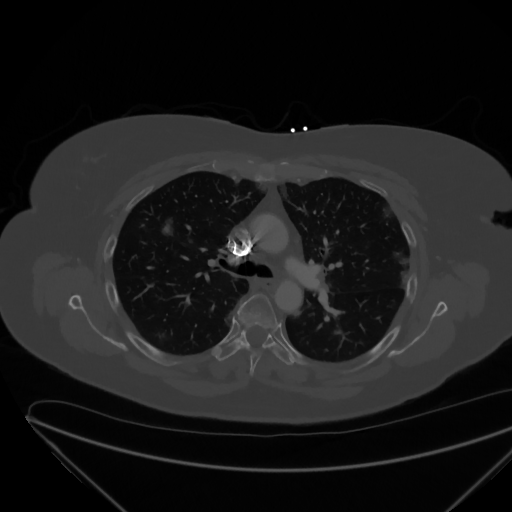

In [283]:
max_view = 1 # just view the first one for demo purposes
for image_file in image_files[0:max_view]:
    print(image_file)
    ds = pydicom.dcmread(image_file)
    try:
        new_image = ds.pixel_array.astype(float)
        scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0
        scaled_image = np.uint8(scaled_image)
        final_image = Image.fromarray(scaled_image)
        print(type(final_image))
        display(final_image)
    except Exception as e:
        print("Couldn't view {}: {}.".format(image_file,e))

### View the DICOM Headers
---
DICOM files have metadata elements embedded in the images. These can also be read and viewed using the `pydicom` package.

In [287]:
ds = pydicom.dcmread(image_files[0],force=True)
display(ds)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 176
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.514382.1623589
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10.474.514382.1623589
(0008,0020) Study Date                          DA: '20181019'
(0008,

In [289]:
# Access individual elements using tags or codes
display(ds.file_meta)
display(ds.ImageType)
display(ds[0x0008, 0x0016])


(0002,0000) File Meta Information Group Length  UL: 176
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.514382.1623589
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'

['ORIGINAL', 'PRIMARY', 'AXIAL']

(0008,0016) SOP Class UID                       UI: CT Image Storage

In [290]:
# View the dicom metadata for all files as a DataFrame
dfs = []
for image_file in image_files:
    ds = pydicom.dcmread(image_file)
    df = pd.DataFrame(ds.values())
    df[0] = df[0].apply(lambda x: pydicom.dataelem.DataElement_from_raw(x) if isinstance(x, pydicom.dataelem.RawDataElement) else x)
    df['name'] = df[0].apply(lambda x: x.name)
    df['value'] = df[0].apply(lambda x: x.value)
    df = df[['name', 'value']]
    df = df.set_index('name').T.reset_index(drop=True)
    df['filename'] = image_file
    df.drop(columns=['Pixel Data'],inplace=True) # drop the pixel data as it's too large and nonsensical to store in a DataFrame
    dfs.append(df)

In [291]:
# Make a master dataframe for all images using only headers in all dataframes
headers = list(set.intersection(*map(set,dfs)))
df = pd.concat([df[headers] for df in dfs])
df.set_index('filename',inplace=True)


In [292]:
display(df)

name,CTDIvol,Manufacturer's Model Name,Acquisition Time,Distance Source to Detector,Series Date,SOP Class UID,Reconstruction Diameter,Table Height,Study Instance UID,Acquisition Date,...,Patient's Name,Columns,Body Part Examined,Contrast/Bolus Volume,Image Orientation (Patient),Content Date,Window Center,Acquisition Number,Specific Character Set,SOP Instance UID
filename,,,,,,,,,,,,,,,,,,,,,
downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623589.dcm,4.756835,iCT 256,193136,1040.0,20181019,1.2.840.10008.5.1.4.1.1.2,409.0,140.2,1.2.826.0.1.3680043.10.474.514382.1623384,20181019,...,"(5, 1, 4, 3, 8, 2, -, 0, 1, 4, 0, 1, 4)",512,CHEST,0.0,"[1, 0, 0, 0, 1, 0]",20181019,"[50, 50]",4,ISO_IR 100,1.2.826.0.1.3680043.10.474.514382.1623589
downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623628.dcm,5.41295,iCT 256,193136,1040.0,20181019,1.2.840.10008.5.1.4.1.1.2,409.0,140.2,1.2.826.0.1.3680043.10.474.514382.1623384,20181019,...,"(5, 1, 4, 3, 8, 2, -, 0, 1, 4, 0, 1, 4)",512,CHEST,0.0,"[1, 0, 0, 0, 1, 0]",20181019,"[50, 50]",4,ISO_IR 100,1.2.826.0.1.3680043.10.474.514382.1623628
downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623615.dcm,5.207914,iCT 256,193136,1040.0,20181019,1.2.840.10008.5.1.4.1.1.2,409.0,140.2,1.2.826.0.1.3680043.10.474.514382.1623384,20181019,...,"(5, 1, 4, 3, 8, 2, -, 0, 1, 4, 0, 1, 4)",512,CHEST,0.0,"[1, 0, 0, 0, 1, 0]",20181019,"[50, 50]",4,ISO_IR 100,1.2.826.0.1.3680043.10.474.514382.1623615
downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623775.dcm,6.971223,iCT 256,193136,1040.0,20181019,1.2.840.10008.5.1.4.1.1.2,409.0,140.2,1.2.826.0.1.3680043.10.474.514382.1623384,20181019,...,"(5, 1, 4, 3, 8, 2, -, 0, 1, 4, 0, 1, 4)",512,CHEST,0.0,"[1, 0, 0, 0, 1, 0]",20181019,"[50, 50]",4,ISO_IR 100,1.2.826.0.1.3680043.10.474.514382.1623775
downloads/514382-014014/1.2.826.0.1.3680043.10.474.514382.1623384/1.2.826.0.1.3680043.10.474.514382.1623388/1.2.826.0.1.3680043.10.474.514382.1623401.dcm,5.782014,iCT 256,193136,1040.0,20181019,1.2.840.10008.5.1.4.1.1.2,409.0,140.2,1.2.826.0.1.3680043.10.474.514382.1623384,20181019,...,"(5, 1, 4, 3, 8, 2, -, 0, 1, 4, 0, 1, 4)",512,CHEST,0.0,"[1, 0, 0, 0, 1, 0]",20181019,"[50, 50]",4,ISO_IR 100,1.2.826.0.1.3680043.10.474.514382.1623401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
downloads/10000364-1530644/2.16.840.1.114274.1818.57465773832909610907978064156916762761/2.16.840.1.114274.1818.563627298879588069511260508963521370554/2.16.840.1.114274.1818.53723774843965736211386203851785752505.dcm,15.494507,SOMATOM Definition Flash,232451.261000,1085.6,19600101,1.2.840.10008.5.1.4.1.1.2,305.0,165.5,2.16.840.1.114274.1818.57465773832909610907978...,19600101,...,"(1, 5, 3, 0, 6, 4, 4, ^, 1, 0, 0, 0, 0, 3, 6, ...",512,CHEST,0.0,"[1, 0, 0, 0, 1, 0]",19600101,"[-645, 50]",5,,2.16.840.1.114274.1818.53723774843965736211386...
downloads/10000364-1530644/2.16.840.1.114274.1818.57465773832909610907978064156916762761/2.16.840.1.114274.1818.563627298879588069511260508963521370554/2.16.840.1.114274.1818.54377816952740772882496305056108267420.dcm,15.483471,SOMATOM Definition Flash,232451.261000,1085.6,19600101,1.2.840.10008.5.1.4.1.1.2,305.0,165.5,2.16.840.1.114274.1818.57465773832909610907978...,19600101,...,"(1, 5, 3, 0, 6, 4, 4, ^, 1, 0, 0, 0, 0, 3, 6, ...",512,CHEST,0.0,"[1, 0, 0, 0, 1, 0]",19600101,"[-645, 50]",5,,2.16.840.1.114274.1818.54377816952740772882496...
downloads/10000364-1530644/2.16.840.1.114274.1818.57465773832909610907978064156916762761/2.16.840.1.114274.1818.563627298879588069511260508963521370554/2.16.840.1.114274.1818.556444352587698059012388807396459349662.dcm,15.571759,SO

In [293]:
## Export the file metadata as a TSV file
filename = "MIDRC_DICOM_metadata.tsv"
df.to_csv(filename, sep='\t')


## The End
---
If you have any questions related to this notebook don't hesitate to reach out to the MIDRC Helpdesk at midrc-support@gen3.org or the author directly at cgmeyer@uchicago.edu

Happy data wrangling!